# Algorithmic Breakdown - LGSSM

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import NamedTuple
from jax.random import multivariate_normal, split
from tqdm.notebook import tqdm, trange
from jax.random import multivariate_normal
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
import jaxkf._src.lgssm as lgssm


import matplotlib.pyplot as plt

## Data

---
Like before, we can describe the dynamical system like so:

$$
\begin{aligned}
\mathbf{z}_{t+1} &= \mathbf{F}\mathbf{z}_t + \boldsymbol{\epsilon}_\mathbf{z} \\
x_t &= \mathbf{H}\mathbf{z}_t + \boldsymbol{\epsilon}_x
\end{aligned}
$$

We can manually define the terms, $\mathbf{F}$ and $\mathbf{H}$, which represent the relationship between the variables. Here they will be

$$
\begin{aligned}
\mathbf{F} &=
\begin{bmatrix}
1 & 1 \\ 0 & 1
\end{bmatrix} \\
\mathbf{H} &=
\begin{bmatrix}
1 & 0 
\end{bmatrix}
\end{aligned}
$$

Here, we assume that the state system is as follows:

$$
\begin{aligned}
\frac{\partial z^1}{\partial t} &= z^1 + z^2 \\
\frac{\partial z^2}{\partial t} &= z^1
\end{aligned}
$$

and we assume that the observation is related like so:

$$
x = z^1
$$

So essentially, we have an augmented the state space dimension, $\mathbf{z} \in \mathbb{R}^2$, which is higher than the observation space, $x \in \mathbb{R}^1$. Our assumption here is that there are higher order dynamics at play behind the scenes. 


#### Parameters

$$
\boldsymbol{\theta} = \{ \mathbf{F}, \mathbf{Q}, \mathbf{H}, \mathbf{R} \}
$$

## Parameters

#### LGSSM Params

In [3]:
class KFParams(NamedTuple):
    transition_matrix : jnp.ndarray
    transition_noise : jnp.ndarray
    observation_matrix : jnp.ndarray
    observation_noise : jnp.ndarray
    
class KFParamsDist(NamedTuple):
    transition_matrix: jnp.ndarray
    transition_noise_dist: tfd.Distribution
    observation_matrix: jnp.ndarray
    observation_noise_dist: tfd.Distribution


In [4]:
# initialize Kalman Filter
state_dim = 2
observation_dim = 1

# init transition model
transition_matrix = jnp.array([[1., 1.], [0., 1.]])   # state transition matrix
transition_noise = 1e-4 * jnp.eye((state_dim))                # state uncertainty

# check sizes
assert transition_matrix.shape == (state_dim, state_dim)
assert transition_noise.shape == (state_dim, state_dim)

# init emission model
observation_matrix = jnp.array([[1., 0.]])             # emission matrix
observation_noise = 50. * jnp.eye((1))                  # emission uncertainty

assert observation_matrix.shape == (observation_dim, state_dim)
assert observation_noise.shape == (observation_dim, observation_dim)


# Prior parameter distribution
mu0 = jnp.array([2.0, 0.0]).astype(float)
Sigma0 = jnp.eye(state_dim) * 1.0

assert mu0.shape == (state_dim,)
assert Sigma0.shape == (state_dim, state_dim)

In [5]:

transition_noise_dist = tfd.MultivariateNormalFullCovariance(
    loc=jnp.zeros(state_dim), 
    covariance_matrix=transition_noise
)


observation_noise_dist = tfd.MultivariateNormalFullCovariance(
    loc=jnp.zeros(observation_dim), 
    covariance_matrix=observation_noise
)


params_dist = KFParamsDist(
    transition_matrix=transition_matrix, 
    transition_noise_dist=transition_noise_dist,
    observation_matrix=observation_matrix, 
    observation_noise_dist=observation_noise_dist
)

params = KFParams(
    transition_matrix=transition_matrix, 
    transition_noise=transition_noise,
    observation_matrix=observation_matrix, 
    observation_noise=observation_noise
)

#### KF State

In [194]:
class State(NamedTuple):
    mu_t: jnp.ndarray
    Sigma_t: jnp.ndarray
    t: int
    
class StatePrior(NamedTuple):
    prior: tfd.Distribution
    

In [195]:
prior_dist = tfd.MultivariateNormalFullCovariance(
    loc=mu0, 
    covariance_matrix=Sigma0
)

state_prior = StatePrior(prior=prior_dist)

In [196]:
prior_dist.covariance().shape, prior_dist.mean().shape

((2, 2), (2,))

## Demo States

In [197]:
from jaxkf._src.functional.sample import sample_step, sample_sequential, sample_sequential_vectorized, sample_event

In [198]:
# init keys - prior, steps
key = jax.random.PRNGKey(411)
key, key_init, key_step = jax.random.split(key, 3)

# initialize state mean
state_init = state_prior.prior.sample(seed=key_init)

assert state_init.shape == (state_dim,)

#### Sequential Sampling

In [199]:
# create time steps
num_time_steps = 100
time_steps = jnp.arange(num_time_steps)

# initialize keys for steps
key_steps = jax.random.split(key_step, num_time_steps)

# initialize states
state_samples, obs_samples = [], []

state = state_init

for i_step in tqdm(key_steps):
    
    # kalman step
    state, obs = sample_step(state, params_dist, i_step)
    
    # append
    state_samples.append(state)
    obs_samples.append(obs)
    

# concatenate all samples
state_samples = jnp.vstack(state_samples)
obs_samples = jnp.vstack(obs_samples)

  0%|          | 0/100 [00:00<?, ?it/s]

##### Scan Fn

In [200]:
# use the scan function
state_samples_, obs_samples_ = sample_sequential(prior_dist, params_dist, key_step, num_time_steps)

# check the shapes
assert state_samples_.shape == (num_time_steps, state_dim)
assert obs_samples_.shape == (num_time_steps, observation_dim)


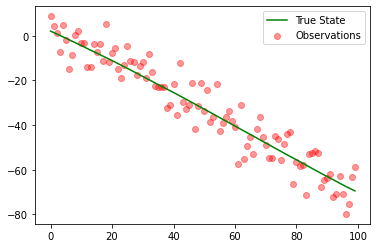

In [201]:
fig, ax = plt.subplots()

ax.plot(time_steps, state_samples[:, 0], label="True State", color="green")
ax.scatter(time_steps, obs_samples, label="Observations", color="red", alpha=0.4)

plt.legend()
plt.show()

#### Vectorized Sampling

In [202]:
%%time

num_samples = 10
num_time_steps = 50
key = 314
sample_prior = True

state_samples, obs_samples = sample_sequential_vectorized(
    prior_dist, 
    params_dist, 
    seed=key, 
    num_samples=num_samples, 
    num_time_steps=num_time_steps,
    sample_prior=sample_prior
)

CPU times: user 895 ms, sys: 10.8 ms, total: 906 ms
Wall time: 915 ms


In [203]:
# check shapes
assert state_samples.shape == (num_samples, num_time_steps, state_dim)
assert obs_samples.shape == (num_samples, num_time_steps, observation_dim)

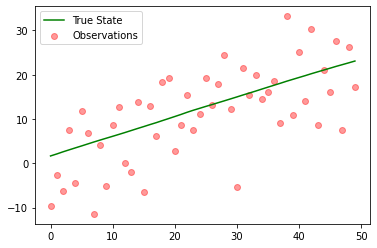

In [204]:
fig, ax = plt.subplots()

t_axes = jnp.arange(num_time_steps)

ax.plot(t_axes, state_samples[0, :, 0], label="True State", color="green")
ax.scatter(t_axes, obs_samples[0, :, 0], label="Observations", color="red", alpha=0.4)

plt.legend()
plt.show()

## Filtering

In [205]:
from jaxkf._src.functional.filter import kalman_step, filter_step_sequential, forward_filter

In [206]:
# init prior state
# state_init = State(
#     mu_t=state_prior.prior.mean(),
#     Sigma_t=state_prior.prior.covariance(),
#     t=0
# )
state_init = (
    state_prior.prior.mean(),
    state_prior.prior.covariance(),
    0
)

### Sequential Filtering

In [207]:
# create time steps
num_time_steps = 100
time_steps = jnp.arange(num_time_steps)


# initialize states
all_states = {"obs": [], "states": []}

state = state_init

for i_obs in tqdm(obs_samples[0]):
    
    # kalman step
    state = kalman_step(i_obs, state, params)
    
    # append
    all_states["obs"].append(i_obs)
    all_states["states"].append(state)
    

# # concatenate all samples
# state_samples = jnp.vstack(state_samples)
# obs_samples = jnp.vstack(obs_samples)

  0%|          | 0/50 [00:00<?, ?it/s]

In [208]:
# pred_states = [(istate.mu_t, state.Sigma_t, istate.t) for istate in all_states["states"]]
mus, sigmas, ts = zip(*all_states["states"])

mus = jnp.vstack(mus)
sigmas = jnp.vstack(sigmas)
ts = jnp.vstack(ts)

In [209]:
mus.shape, sigmas.shape, ts.shape

((50, 2), (100, 2), (50, 1))

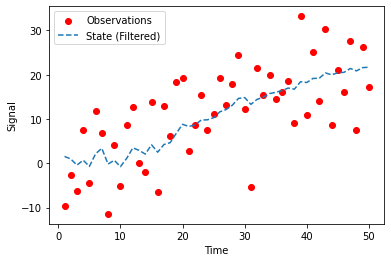

In [210]:
fig, ax = plt.subplots()


ax.scatter(ts[..., 0], all_states["obs"], color="red", label="Observations")
ax.plot(ts[..., 0], mus[:, 0], label="State (Filtered)", linestyle="--")

ax.set(xlabel="Time", ylabel="Signal")

plt.legend()
plt.show()


#### Sequential (Scan)

In [236]:
# init prior state
state_init = State(
    mu_t=state_prior.prior.mean(),
    Sigma_t=state_prior.prior.covariance(),
    t=0
)
# state_init = (
#     state_prior.prior.mean(),
#     state_prior.prior.covariance(),
#     0
# )
# init params
params = KFParams(
    transition_matrix=transition_matrix, 
    transition_noise=transition_noise,
    observation_matrix=observation_matrix, 
    observation_noise=observation_noise
)

In [237]:
%%time

# perform the filtering sequentially
mus, sigmas, log_likelihoods, mu_cond, Sigmas_cond, ts = filter_step_sequential(obs_samples[0], state_prior, params)

CPU times: user 301 ms, sys: 6.26 ms, total: 308 ms
Wall time: 315 ms


In [238]:
ts.shape, mus.shape

((50,), (50, 2))

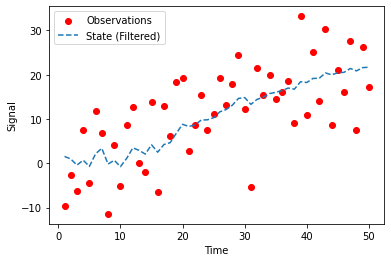

In [239]:
fig, ax = plt.subplots()


ax.scatter(ts, obs_samples[0], color="red", label="Observations")
ax.plot(ts, mus[:, 0], label="State (Filtered)", linestyle="--")

ax.set(xlabel="Time", ylabel="Signal")

plt.legend()
plt.show()


### Vectorized

In [273]:
mus, sigmas, log_likelihoods, mu_cond, Sigmas_cond, ts = forward_filter(obs_samples, state_prior, params)

mus.shape, sigmas.shape, ts.shape

((10, 50, 2), (10, 50, 2, 2), (10, 50))

In [274]:
- jnp.mean(log_likelihoods[0], axis=-1)

DeviceArray(3.4174175, dtype=float32)

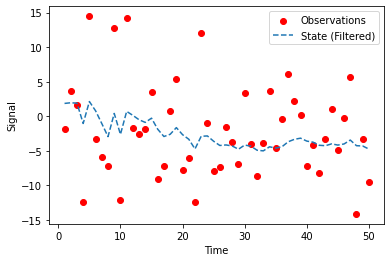

In [257]:
fig, ax = plt.subplots()

batch_idx = 3

ax.scatter(ts[batch_idx], obs_samples[batch_idx], color="red", label="Observations")
ax.plot(ts[batch_idx], mus[batch_idx, :, 0], label="State (Filtered)", linestyle="--")

ax.set(xlabel="Time", ylabel="Signal")

plt.legend()
plt.show()

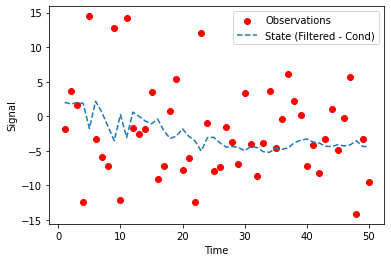

In [255]:
fig, ax = plt.subplots()

batch_idx = 3

ax.scatter(ts[batch_idx], obs_samples[batch_idx], color="red", label="Observations")
ax.plot(ts[batch_idx], mu_cond[batch_idx, :, 0], label="State (Filtered - Cond)", linestyle="--")

ax.set(xlabel="Time", ylabel="Signal")

plt.legend()
plt.show()

## Training (Numpyro)

In [275]:
import treex as tx

In [ ]:
class LGSSM(tx.Module):
    

In [277]:
import numpyro
import numpyro.distributions as dist
from numpyro import diagnostics, infer
from numpyro.contrib.control_flow import scan

### 1D Data

In [720]:
def kf_model(x=None, seq_len: int=0, batch:int=0, x_dim: int=1, future_steps=0, z_dim: int=2, ):
    
    # parse sizes
    if x is not None:
        # print("Input:", x.shape)
        # z_init = x[0, ...]
        seq_len, batch, x_dim = x.shape
    # else:
    #     # init prior
    
    # transition model
    # transition_matrix = numpyro.deterministic("transition_matrix", jnp.array([[0., 1.], [1., 1.]]))
    # transition_noise = numpyro.param(
    #     "transition_noise", 1e-2 * jnp.ones(z_dim),
    #     constraint=constraints.positive
    # )
    transition_matrix = numpyro.sample(
        "transition_matrix", 
        dist.Normal(
            jnp.zeros((z_dim, z_dim)), jnp.ones((z_dim, z_dim))
            
        )
    )
    transition_noise = numpyro.sample(
        "transition_noise",
        dist.Normal(jnp.ones(z_dim), jnp.ones(z_dim))
    )
    
    # emission model
    # emission_matrix = numpyro.deterministic("emission_matrix", jnp.array([[0., 1.]]).T)
    # emission_noise = numpyro.param(
    #     "emission_noise", 1e-2 * jnp.ones(x_dim),
    #     constraint=constraints.positive
    # )
    emission_matrix = numpyro.sample(
        "emission_matrix", 
        dist.Normal(
            jnp.zeros((z_dim, x_dim)), jnp.ones((z_dim, x_dim))
            
        )
    )
    emission_noise = numpyro.sample(
        "emission_noise",
        dist.Normal(jnp.ones(x_dim), jnp.ones(x_dim))
    )
    
    # transition function
    def body(carry, t):
        # unroll data
        z_prev, *_ = carry
        # sample transition dist
        # print("z_prev:", z_prev.shape)
        z = numpyro.sample("z", dist.Normal(loc=z_prev @ transition_matrix, scale=transition_noise))
        # sample emission dist
        # print("z:", z.shape)
        x = numpyro.sample("x", dist.Normal(loc=z @ emission_matrix, scale=emission_noise))
        # print("Loop:", z_prev.shape, z.shape, x.shape)
        return (z,), None
    
    z_init = jnp.zeros((batch, z_dim))
    with numpyro.handlers.condition(data={"x": x}):
        scan(body, (z_init,), jnp.arange(seq_len + future_steps))

In [721]:
# def kf_model(x=None, seq_len: int=0, batch:int=0, x_dim: int=1, z_dim: int=2, future_steps=0):
    
#     # parse sizes
#     if x is not None:
#         # print("Input:", x.shape)
#         # z_init = x[0, ...]
#         seq_len, batch, x_dim = x.shape
#     # else:
#     #     # init prior
#     z_init = jnp.zeros((batch, z_dim))
#     numpyro.deterministic("z_init", z_init)
    
#     # print("Init:", z_init.shape)
    
    
# #     # transition model
# #     transition_matrix = jnp.array([[0., 1.], [1., 1.]]) 
# #     numpyro.deterministic("transition_matrix", transition_matrix)
    
# #     trans_noise_diagonal = numpyro.param(
# #         "transition_noise", 1e-4 * jnp.ones(2),
# #         constraint=constraints.positive
# #     )
# #     trans_noise_matrix = jnp.diag(trans_noise_diagonal)
                                         
# #     # emission model
# #     emission_matrix = jnp.array([[0., 1.]]).T
# #     numpyro.deterministic("emission_matrix", emission_matrix)
    
# #     emission_noise_diagonal = numpyro.param(
# #         "transition_noise", 1e-2 * jnp.ones(1),
# #         constraint=constraints.positive
# #     )
# #     emission_noise_matrix = jnp.diag(emission_noise_diagonal)
    
#     # transition function
#     def body(carry, t):
#         # unroll data
#         z_prev, *_ = carry
#         # sample transition dist
#         # print("z_prev:", z_prev.shape)
#         z = numpyro.sample("z", dist.MultivariateNormal(loc=z_prev @ transition_matrix, covariance_matrix=trans_noise_matrix))
#         # sample emission dist
#         # print("z:", z.shape)
#         x = numpyro.sample("x", dist.MultivariateNormal(loc=z @ emission_matrix, covariance_matrix=emission_noise_matrix))
#         # print("Loop:", z_prev.shape, z.shape, x.shape)
#         return (z,), None
    
#     with numpyro.handlers.condition(data={"x": x}):
#         scan(body, (z_init,), jnp.arange(seq_len + future_steps))

### Prior

In [722]:
%%time

x = obs_samples.transpose((1,0,2))
print("Data:", x.shape)

rng_key = jax.random.PRNGKey(0)
rng_key, rng_key_prior, rng_key_infer, rng_key_posterior = jax.random.split(rng_key, 4)

# Prior prediction
predictive = infer.Predictive(kf_model, num_samples=10)

# without x
print("No Input")
prior_predictive = predictive(rng_key_prior, None, *x.shape, future_steps=10)

# with x
print("Input")
prior_predictive = predictive(rng_key_prior, x)


Data: (50, 10, 1)
No Input
Input
CPU times: user 3.69 s, sys: 91.2 ms, total: 3.78 s
Wall time: 3.86 s


In [687]:
len_train = x.shape[0]
x_pred = prior_predictive["x"]
x_pred.shape, x.shape

((10, 50, 10, 1), (50, 10, 1))

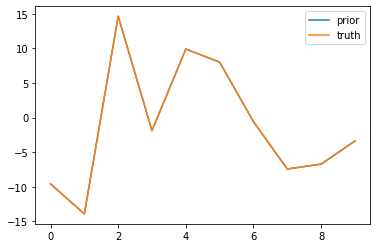

In [688]:
fig, ax = plt.subplots()

ax.plot(x_pred[0, 0, :, :].squeeze(), label="prior")
ax.plot(x[0, :, :].squeeze(), label="truth")

plt.legend()

plt.show()

## Training

In [689]:
from numpyro import diagnostics, infer, optim
from numpyro.distributions import constraints

In [690]:
# %%time
# Posterior prediction
# predictive = infer.Predictive(model, params=svi_result.params, num_samples=10)
# posterior_predictive = predictive(rng_key_posterior, None, *x.shape, future_steps=10)

## Sampling

In [673]:
# Inference
kernel = infer.NUTS(kf_model)
mcmc = infer.MCMC(kernel, num_warmup=200, num_samples=100)
mcmc.run(rng_key_infer, x)
posterior_samples = mcmc.get_samples()

sample: 100%|█| 300/300 [00:06<00:00, 48.65it/s, 1023 steps of size 7.28e-07. ac


In [674]:
%%time
# Posterior prediction
predictive = infer.Predictive(kf_model, posterior_samples=posterior_samples)
posterior_predictive = predictive(rng_key_posterior, None, *x.shape, future_steps=0)

CPU times: user 940 ms, sys: 8.04 ms, total: 948 ms
Wall time: 948 ms


In [675]:
x_pred = posterior_predictive["x"]



In [676]:
lb, pred, ub = jnp.percentile(x_pred, jnp.array([0.1, 0.5, 0.95]), axis=0)

In [677]:
x.shape, x_pred.shape, pred.shape

((50, 10, 1), (100, 50, 10, 1), (50, 10, 1))

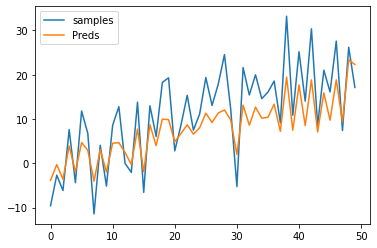

In [678]:
fig, ax = plt.subplots()

ax.plot(x[:, 0, :], label="samples")
ax.plot(pred[:, 0, :], label="Preds")

plt.legend()
plt.show()

In [ ]:
len_train = x.shape[0]
x_pred_trn = posterior_predictive["x"][:, :len_train, 0]
x_hpdi_trn = diagnostics.hpdi(x_pred_trn)[:, :, 0]
x_pred_tst = posterior_predictive["x"][:, len_train:, 0]
x_hpdi_tst = diagnostics.hpdi(x_pred_tst)[:, :, 0]
len_test = x_pred_tst.shape[1]

In [723]:
def guide(
    x=None, seq_len: int=0, batch:int=0, x_dim: int=1, z_dim: int=2, future_steps=0
) -> None:

    if x is not None:
        *_, x_dim = x.shape

    # transition model
    phi = numpyro.param("phi", jnp.ones((x_dim, x_dim)))
    sigma = numpyro.param(
        "sigma", 1e-2 * jnp.ones(x_dim),
        constraint=constraints.positive
    )
    
    z = numpyro.sample("z", dist.Normal(x @ phi, sigma))

In [724]:
%%time
# optimizers
lr = 1e-2
adam = optim.Adam(lr)

# def guide(x=None, seq_len: int=0, batch:int=0, x_dim: int=1, future_steps=0, z_dim: int=2, ):
#     return None



n_epochs = 50_000

# Inference
svi = infer.SVI(kf_model, guide, adam, infer.Trace_ELBO())
svi_result = svi.run(rng_key_infer, n_epochs, x)

100%|█| 50000/50000 [00:08<00:00, 5901.65it/s, init loss: nan, avg. loss [47501-


CPU times: user 12.1 s, sys: 206 ms, total: 12.3 s
Wall time: 12.4 s


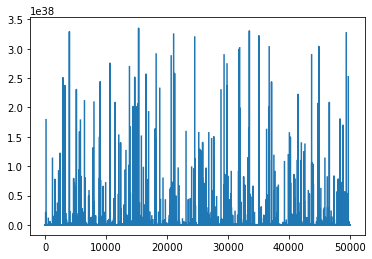

In [725]:
plt.plot(svi_result.losses)

In [726]:
svi_result.params

{'phi': DeviceArray([[1.0124203]], dtype=float32),
 'sigma': DeviceArray([0.00953189], dtype=float32)}

In [731]:

# Posterior prediction
predictive = infer.Predictive(kf_model, params=svi_result.params, num_samples=20)
posterior_predictive = predictive(rng_key_posterior, None, *x.shape, future_steps=10)

In [732]:
x_pred.shape, x.shape

((20, 50, 10, 1), (50, 10, 1))

In [733]:
x_pred = posterior_predictive["x"]

lb, pred, ub = jnp.percentile(x_pred, jnp.array([0.1, 0.5, 0.95]), axis=0)

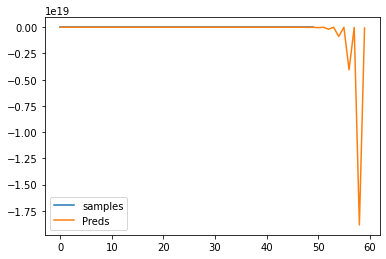

In [734]:
fig, ax = plt.subplots()

ax.plot(x[:, 0, :], label="samples")
ax.plot(pred[:, 0, :], label="Preds")

plt.legend()
plt.show()

In [710]:
x_pred.shape

(10, 50, 10, 1)

In [281]:
d = jnp.ones(2)
d = jnp.diag(d)
d

DeviceArray([[1., 0.],
             [0., 1.]], dtype=float32)

In [ ]:
# initialize Kalman Filter
state_dim = 2
observation_dim = 1

# init transition model
transition_matrix = jnp.array([[1., 1.], [0., 1.]])   # state transition matrix
transition_noise = 1e-4 * jnp.eye((state_dim))                # state uncertainty

# check sizes
assert transition_matrix.shape == (state_dim, state_dim)
assert transition_noise.shape == (state_dim, state_dim)

# init emission model
observation_matrix = jnp.array([[1., 0.]])             # emission matrix
observation_noise = 50. * jnp.eye((1))                  # emission uncertainty

assert observation_matrix.shape == (observation_dim, state_dim)
assert observation_noise.shape == (observation_dim, observation_dim)


# Prior parameter distribution
mu0 = jnp.array([2.0, 0.0]).astype(float)
Sigma0 = jnp.eye(state_dim) * 1.0

assert mu0.shape == (state_dim,)
assert Sigma0.shape == (state_dim, state_dim)

##

In [258]:


# initia
transition_noise_dist = lgssm.MultivariateNormal(jnp.zeros(state_dim), transition_noise)

observation_noise_dist = lgssm.MultivariateNormal(jnp.zeros(observation_dim), observation_noise)

initial_state_prior_dist = lgssm.MultivariateNormal(mu0, Sigma0)

kf_model = lgssm.LinearGaussianStateSpaceModel(
    transition_matrix, transition_noise_dist,
    observation_matrix, observation_noise_dist,
    initial_state_prior_dist
)

In [259]:
%%time

log_probs, mus, sigmas, mus_cond, sigmas_cond = kf_model.forward_filter(obs_samples[0])


mus.shape, sigmas.shape

CPU times: user 361 ms, sys: 6.23 ms, total: 367 ms
Wall time: 365 ms


((50, 2), (50, 2, 2))

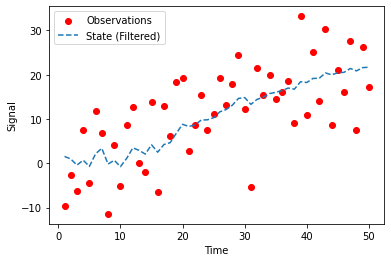

In [261]:
fig, ax = plt.subplots()


ax.scatter(ts[0], obs_samples[0], color="red", label="Observations")
ax.plot(ts[0], mus[:, 0], label="State (Filtered)", linestyle="--")

ax.set(xlabel="Time", ylabel="Signal")

plt.legend()
plt.show()

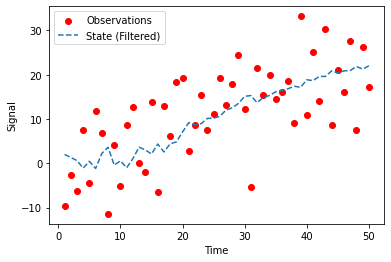

In [263]:
fig, ax = plt.subplots()


ax.scatter(ts[0], obs_samples[0], color="red", label="Observations")
ax.plot(ts[0], mus_cond[:, 0], label="State (Filtered)", linestyle="--")

ax.set(xlabel="Time", ylabel="Signal")

plt.legend()
plt.show()

In [19]:
state.shape, obs.shape

((2,), (1,))

In [20]:
# initialize states
all_states, all_obs = [], []

state = state_init

for i_step in tqdm(sample_keys):
    
    # kalman step
    state, (state, obs) = kf_model.sample_step(state, i_step)
    
    # append
    all_states.append(state)
    all_obs.append(obs)
    

all_states = jnp.vstack(all_states)
all_obs = jnp.vstack(all_obs)

NameError: name 'sample_keys' is not defined

TypeError: list indices must be integers or slices, not tuple

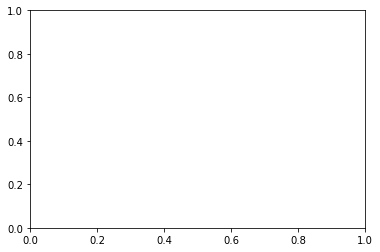

In [21]:
fig, ax = plt.subplots()

ax.plot(time_steps, all_states[:, 0], label="True State", color="green")
ax.scatter(time_steps, all_obs, label="Observations", color="red", alpha=0.4)

plt.legend()
plt.show()

In [112]:
num_time_steps = 100

all_states, all_obs = kf_model.sample(seed=123, sample_shape=10, num_timesteps=num_time_steps)
states.shape, all_obs.shape

((1, 100, 2), (10, 100, 1))

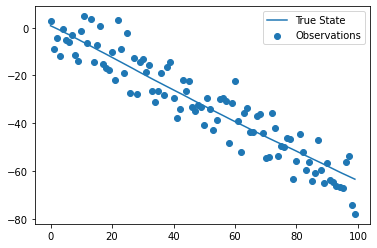

In [117]:
fig, ax = plt.subplots()

ax.plot(time_steps, all_states[3, :, 0], label="True State")
ax.scatter(time_steps, all_obs[3, :, 0], label="Observations")

plt.legend()
plt.show()

In [100]:
mu0.shape

(2,)

In [130]:
kf_model.sample_step(mu0, key)

(2,) (2, 1) (1,)


TypeError: dot_general requires contracting dimensions to have the same shape, got [1] and [2].

---

## Filtering

1. Do Forward Filter for a batch of inputs
2. Init prior mean, cov
3. Loop Through Kalman Step (mu0, cov0)

In [11]:
from jaxkf._src.functional.ops import kalman_step

In [14]:
num_time_steps = 15

states_preds, states_corrs = [], []

for i_t_step in trange(num_time_steps):
    
    # kalman step
    state_pred, state_corrected = kalman_step(
    
    pass

SyntaxError: invalid syntax (2776370347.py, line 12)

### Kalman Filter Step

### Predict Step

## Smoothing

### Posterior Marginals (Alternative)

## Log Probability

## Model

##### Initialize Parameters

In [12]:
kf_params = KFParams(
    F=F, R=R,
    H=H, Q=Q
)

## State

In [13]:
class State(NamedTuple):
    mu_t: jnp.ndarray
    Sigma_t: jnp.ndarray
    t: int

In [14]:
# init state
init_mean = jnp.array([2., 0.])
init_cov = jnp.eye(init_mean.shape[0])

assert init_mean.shape == (state_dim,)
assert init_cov.shape == (state_dim, state_dim)

##### Initialize

In [16]:
init_state = State(
    mu_t=init_mean,
    Sigma_t=init_cov,
    t=0
)

## Sampling



1. Sample from the initial state

$$
\mathbf{x_0} \sim \mathcal{N}(\boldsymbol{\mu}_0, \boldsymbol{\Sigma}_0; \text{key})
$$


In [24]:
key = jax.random.PRNGKey(314)


# sample from initial state
x0_key, key = split(key, 2)

state_t = multivariate_normal(key=x0_key, mean=init_mean, cov=init_cov)


In [ ]:
def sample_step(key, state, params, n_samples=1):
    
    xt_key, trans_key, obs_key = split(key, 3)
    
    # unroll state
    mu_t = init_state.mu_t
    sigma_t = init_state.Sigma_t
    
    # unroll params
    F = params.F
    R = params.R
    H = params.H
    Q = params.Q
    
    
    state_t = multivariate_normal(key=x0_key, mean=mu_t, cov=Sigma_0)
    
    # new state
    
    
    return key

In [25]:
def sample(key, init_state, params, n_samples=1):
    """Sample states"""
    , key = split(key, 2)
    
    mu_0 = init_state.mu_t
    Sigma_0 = init_state.Sigma_t
    t = init_state.t
    
    state_t = multivariate_normal(key=x0_key, mean=mu_0, cov=Sigma_0)
    
    
    pass

In [27]:
sample(key, init_state, kf_params)

## Code Layout



```python
class KFDist:
    def __init__(self):
        """Initialize the parameters"""
        pass
    
    def filter_states(self, obs):
        """Perform the filtering operation
        p(x_{1:T}|y_{1:T})
        """
        return None
    
    def log_prob(self, obs):
        """p(x_"""
        return None
    
    def rsample(self, n_samples):
        return None
    
```

### State

### Parameters

### Filter Function

In [ ]:
# mu_t, sigma_t, x_t

# get matrices
A = 

In [ ]:
def kalman_step(mu_t, sigma_t, x_t)

### Sample Function

### Training

In [ ]:
import numpyro
import numpyro.distributions

In [ ]:
def kf_model(obs):
    
    R = numpyro.sample("R", dist